<a href="https://colab.research.google.com/github/ntu7de/ml4va-project-f2023/blob/main/ML4VA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML4VA Project
By Sebastian Borromeo (uwg3xs@virginia.edu), Franceska Padilla Coo (fdp6kz@virginia.edu), and Patrick Yuson (ntu7de@virginia.edu)


## Data Preprocessing
**Database Links:**


1.   COVID Data: https://data.virginia.gov/Government/VDH-COVID-19-PublicUseDataset-Cases/bre9-aqqr
2.   Locality Data: https://datausa.io/profile/geo/virginia
3.   Population Data: https://demographics.coopercenter.org/virginia-population-estimates



In [ ]:
# Import some common packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
import math

from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

import requests
import requests.exceptions

import time

np.random.seed(42)

# Preparing and Combining Data Sets (Skip if csv already prepared)

In [ ]:
# read the two datasets
covid = pd.read_csv("VDH-COVID-19-PublicUseDataset-Cases_20231101.csv")
income = pd.read_csv("Income by Location.csv")

# change the c in 'city' to 'C'
for i in range(len(income)):
  income_locality = income.at[i, 'Geography']
  try:
    index = income_locality.index('city')
    new_locality = income_locality[:index] + 'C' + income_locality[index + 1:]
    income.at[i, 'Geography'] = new_locality
  except:
    continue

# Remove commas from numeric entries so that they won't be read as objects
covid['Total Cases'] = covid['Total Cases'].str.replace(',', '', regex=True).astype(float)
covid['Hospitalizations'] = covid['Hospitalizations'].str.replace(',', '', regex=True).astype(float)
covid['Deaths'] = covid['Deaths'].str.replace(',', '', regex=True).astype(float)

print(income.info())
print(covid.info())

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Remove covid data from any year above 2021
string_to_drop = '2023'
mask = covid['Report Date'].str.contains(string_to_drop)
covid = covid[~mask]

string_to_drop = '2022'
mask = covid['Report Date'].str.contains(string_to_drop)
covid = covid[~mask]

In [ ]:
# Add 'Report Year' column of type int
covid['Report Year'] = covid['Report Date'].str.slice(6, 10).astype(int)
print(covid.head())

    Report Date   FIPS   Locality VDH Health District  Total Cases  \
68   04/17/2020  51720     Norton           Lenowisco          0.0   
932  03/24/2020  51001   Accomack       Eastern Shore          1.0   
933  03/24/2020  51003  Albemarle    Thomas Jefferson          2.0   
934  03/24/2020  51005  Alleghany           Alleghany          0.0   
935  03/24/2020  51007     Amelia            Piedmont          0.0   

     Hospitalizations  Deaths  Report Year  
68                0.0     0.0         2020  
932               0.0     0.0         2020  
933               0.0     0.0         2020  
934               0.0     0.0         2020  
935               0.0     0.0         2020  


In [ ]:
# Create 'Household Income' column in covid dataset
covid['Household Income'] = None

In [ ]:
# Algorithm to add corresponding Household Incomes to each entry of COVID dataset
for i in range(len(covid)):
  # print(i)
  covid_index = covid.index[i]
  covid_locality = covid.at[covid_index, 'Locality']
  condition = (income['Year'] == covid.at[covid_index, 'Report Year']) & (income['Geography'].str.contains(covid.at[covid_index, 'Locality'])) & (income['Race'] == 'Total')
  result = income[condition]
  household_income = result.at[result.index[0], 'Household Income by Race']
  covid.at[covid_index, 'Household Income'] = household_income

print(covid.head())


In [ ]:
population = pd.read_csv("Virginia Population Estimates 2020-2022.csv")

In [ ]:
population.head()

In [ ]:
population['2020 Census'] = population['2020 Census'].str.replace(',', '', regex=True).astype(int)
population['2021 Estimate'] = population['2021 Estimate'].str.replace(',', '', regex=True).astype(int)
population.info()

In [ ]:
# Create 'Population' column in covid dataset
covid['Population'] = 0

In [ ]:
# Algorithm to add corresponding Locality Populations to each entry of COVID dataset
for i in range(len(covid)):
  covid_index = covid.index[i]
  covid_locality = covid.at[covid_index, 'Locality']
  covid_year = covid.at[covid_index, 'Report Year']
  condition = population['Locality'].str.contains(covid.at[covid_index, 'Locality'])
  result = population[condition]

  if covid_year == 2020:
    added_population = result.at[result.index[0], '2020 Census']
  else:
    added_population = result.at[result.index[0], '2021 Estimate']

  covid.at[covid_index, 'Population'] = added_population

In [ ]:
covid.info()

In [ ]:
covid.head(10)

In [ ]:
# Code to download Final Dataset CSV
csv_file_path = "Final Dataset.csv"
covid.to_csv(csv_file_path, index=False)

# RUN IMPORTS (FIRST BLOCK) AND THEN CONTINUE HERE

In [ ]:
# Reading from csv containing all cities and counties
df_va_cities_and_counties = pd.read_csv("./va.csv")
df_va_cities_and_counties.head(2)

,County/City
0,Accomack County
1,Albemarle County


In [ ]:
# Method for API calls
def get_api_response(url, params):
    try:
        response = requests.request("GET", url, params=params)
        response.raise_for_status()

    except requests.exceptions.HTTPError as errh:
        return "An Http Error occurred: " + repr(errh)
    except requests.exceptions.ConnectionError as errc:
        return "An Error Connecting to the API occurred: " + repr(errc)
    except requests.exceptions.Timeout as errt:
        return "A Timeout Error occurred: " + repr(errt)
    except requests.exceptions.RequestException as err:
        return "An Unknown Error occurred: " + repr(err)

    return response.json()

In [ ]:
virginia_db_url = "https://data.virginia.gov/resource/bre9-aqqr.json?$select=distinct FIPS, Locality"

distinct_fips_json = get_api_response(virginia_db_url, "")
df_localities = pd.DataFrame(distinct_fips_json)
print(f"Number of Localities: {len(df_localities)}")
df_localities.head(2)

Number of Localities: 133


,FIPS,Locality
0,51001,Accomack
1,51003,Albemarle


In [ ]:
# Adding "County" or "City"
for index, row in df_localities.iterrows():
  locality_name = row[1]
  for index, row2 in df_va_cities_and_counties.iterrows():
    if locality_name in row2[0]:
      row[1] = row2[0]

df_localities.head(2)

,FIPS,Locality
0,51001,Accomack County
1,51003,Albemarle County


# Geocoding API

## Skip to avoid regrabbing coordinates and use coordinates.csv

In [ ]:
coordinates = []

url = "https://geocode.maps.co/search?q="

for index, row in df_localities.iterrows():
  locality = row[1]
  time.sleep(1) # To avoid getting limited
  json = get_api_response(f"{url}{locality}, Virginia", "")

  lat = json[0]['lat']
  lon = json[0]['lon']
  coordinates.append({"latitude": lat, "longitude": lon})

In [ ]:
df_coorindates = pd.DataFrame(coordinates, dtype=float)
df_coorindates.to_csv('coordinates.csv', index=False)
df_coorindates.head(2)

# Go from here to avoid regrabbing coordinates

In [ ]:
df_coorindates = pd.read_csv("coordinates.csv")

In [ ]:
df_localities = df_localities.join(df_coorindates)
df_localities.head(2)

,FIPS,Locality,latitude,longitude
0,51001,Accomack County,37.742221,-75.674354
1,51003,Albemarle County,38.008511,-78.608675


In [ ]:
lat_lon_lookup_table = df_localities[['FIPS', 'latitude','longitude']]
lat_lon_lookup_table.head(2)

,FIPS,latitude,longitude
0,51001,37.742221,-75.674354
1,51003,38.008511,-78.608675


In [ ]:
covid = pd.read_csv("Final Dataset.csv")
lat_lon_lookup_table['FIPS'] = lat_lon_lookup_table['FIPS'].astype(int)

# Using lookup table
covid = pd.merge(covid, lat_lon_lookup_table, on='FIPS', how='left')

#Dropping FIPS because it's just a 5-digit code representing locality
covid = covid.drop("FIPS", axis=1)

# Not Relevant
covid = covid.drop("Report Date", axis=1)
covid = covid.drop("Report Year", axis=1)

#Error in Dataset
covid = covid.drop(0, axis=0)

# Drop after index 86186 because it just repeats the data
covid = covid.drop(index=range(86186, len(covid)))
covid.info()

<ipython-input-11-bd0ecac593f4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lat_lon_lookup_table['FIPS'] = lat_lon_lookup_table['FIPS'].astype(int)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 86185 entries, 1 to 86185
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Locality             86185 non-null  object 
 1   VDH Health District  86185 non-null  object 
 2   Total Cases          86185 non-null  float64
 3   Hospitalizations     86185 non-null  float64
 4   Deaths               86185 non-null  float64
 5   Household Income     86185 non-null  int64  
 6   Population           86185 non-null  int64  
 7   latitude             86185 non-null  float64
 8   longitude            86185 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 6.6+ MB


In [ ]:
covid.head()

,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,Household Income,Population,latitude,longitude
1,Accomack,Eastern Shore,1.0,0.0,0.0,46178,33413,37.742221,-75.674354
2,Albemarle,Thomas Jefferson,2.0,0.0,0.0,84643,112395,38.008511,-78.608675
3,Alleghany,Alleghany,0.0,0.0,0.0,48513,15223,37.816702,-80.022717
4,Amelia,Piedmont,0.0,0.0,0.0,63918,13265,37.331966,-78.008448
5,Amherst,Central Virginia,1.0,0.0,0.0,57368,31307,37.599755,-79.148370


In [ ]:
##Check for NaN values
covid.isnull().any(axis=0)
#No NaN rows!

Locality               False
VDH Health District    False
Total Cases            False
Hospitalizations       False
Deaths                 False
Household Income       False
Population             False
latitude               False
longitude              False
dtype: bool

In [ ]:
covid.describe()

,Total Cases,Hospitalizations,Deaths,Household Income,Population,latitude,longitude
count,86185.000000,86185.000000,86185.000000,86185.000000,8.618500e+04,86185.000000,86185.000000
mean,3444.239665,158.931073,55.095028,65096.776968,6.504495e+04,37.576965,-78.495697
std,7889.893129,369.458454,109.092354,23551.413628,1.277987e+05,0.693133,1.735662
min,0.000000,0.000000,0.000000,30058.000000,2.226000e+03,36.585972,-83.097321
25%,264.000000,18.000000,5.000000,49486.000000,1.477500e+04,37.024130,-79.590798
50%,1137.000000,53.000000,21.000000,57911.000000,2.587400e+04,37.445229,-78.149582
75%,3071.000000,136.000000,60.000000,76528.000000,5.447700e+04,38.032030,-77.215314
max,116752.000000,4302.000000,1210.000000,156821.000000,1.150309e+06,39.185218,-75.383530


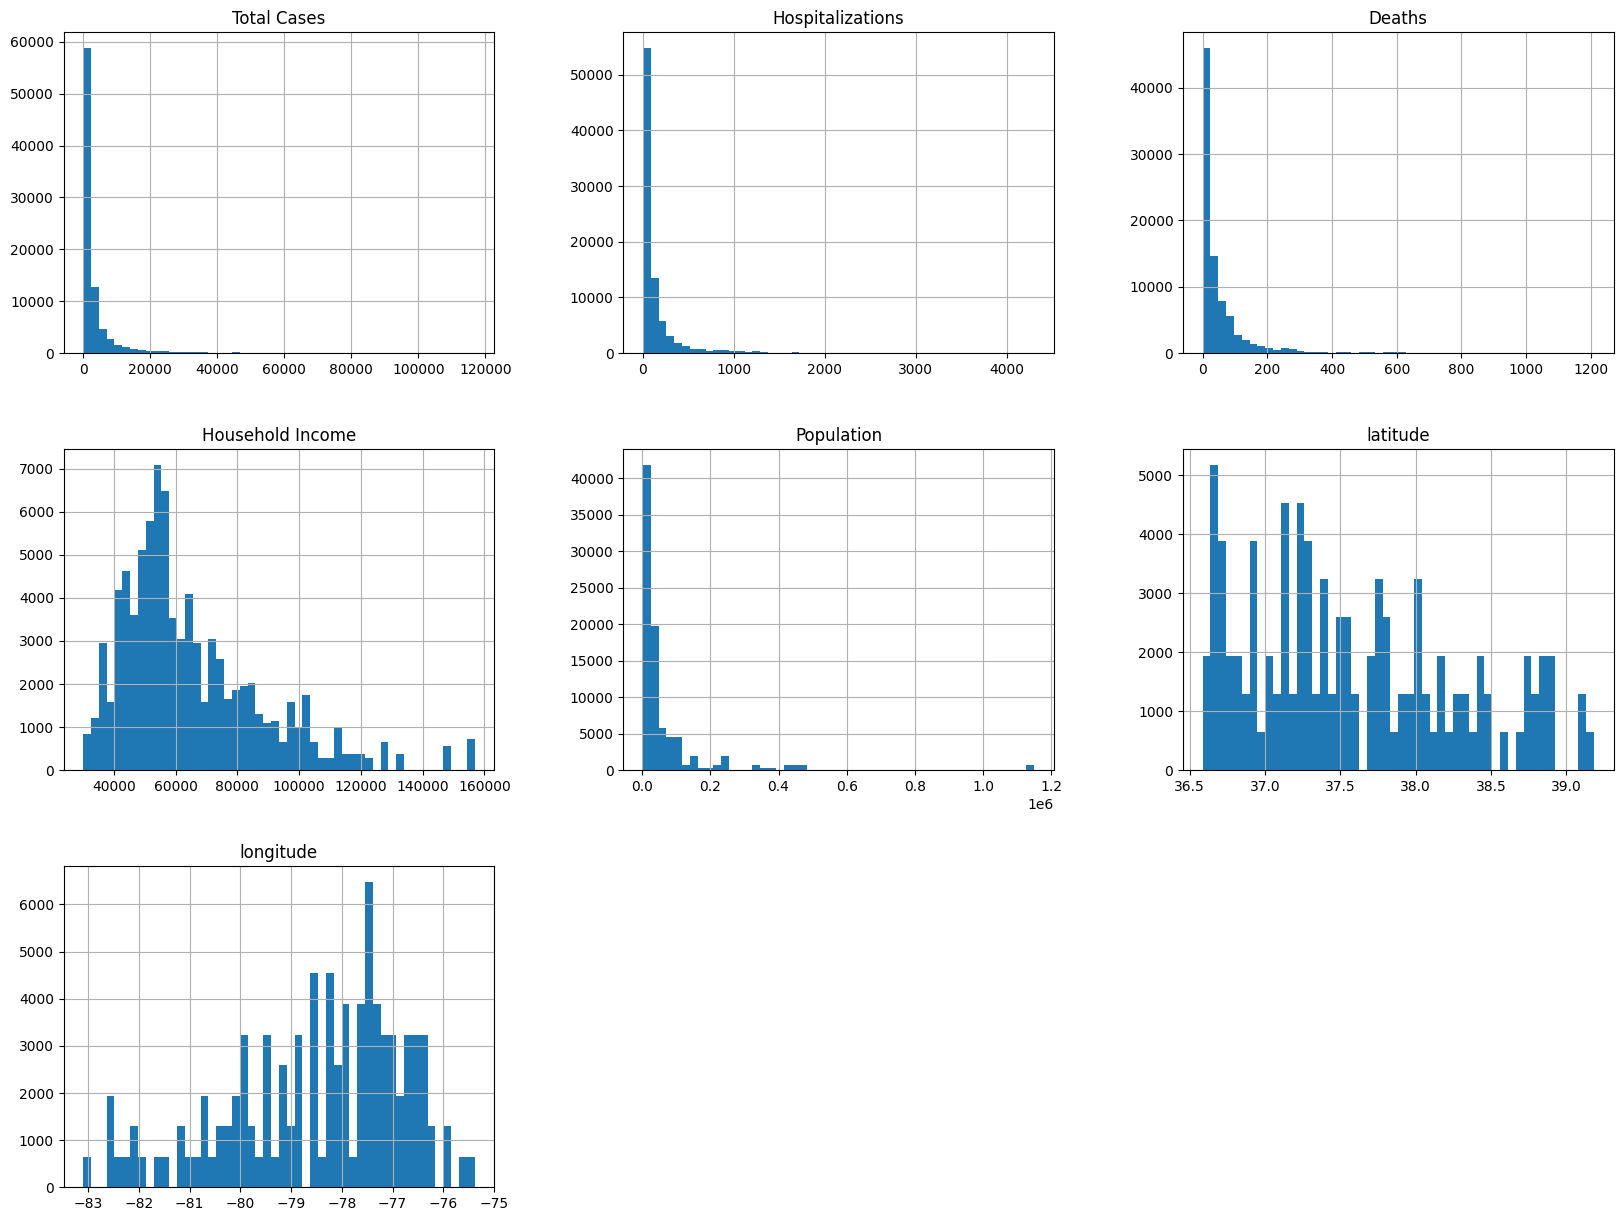

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
covid.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(covid, test_size=0.2, random_state=42)

In [ ]:
print( train_set.shape )
print( test_set.shape )

(68948, 9)
(17237, 9)


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(covid, covid["Locality"]):
    strat_train_set = covid.iloc[train_index]
    strat_test_set = covid.iloc[test_index]

In [ ]:
strat_test_set["Locality"].value_counts() / len(strat_test_set)

Charlottesville    0.007542
Manassas Park      0.007542
Floyd              0.007542
Charlotte          0.007542
Buckingham         0.007542
                     ...   
Louisa             0.007484
Lancaster          0.007484
Greensville        0.007484
Prince George      0.007484
King and Queen     0.007484
Name: Locality, Length: 133, dtype: float64

# Clustering (DO NOT RUN IF RUNNING REGRESSION)

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("Locality", axis = 1, inplace=True)

<ipython-input-20-5e94d22a0cea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("Locality", axis = 1, inplace=True)
<ipython-input-20-5e94d22a0cea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("Locality", axis = 1, inplace=True)


In [ ]:
covid = strat_train_set.copy()

In [ ]:
import seaborn as sns
corr_matrix = covid.corr()
corr_matrix.shape

<ipython-input-22-40061935ddda>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = covid.corr()


(7, 7)

<ipython-input-23-c07768d0e8da>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(covid.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')


Text(0.5, 1.0, 'Correlation Heatmap')

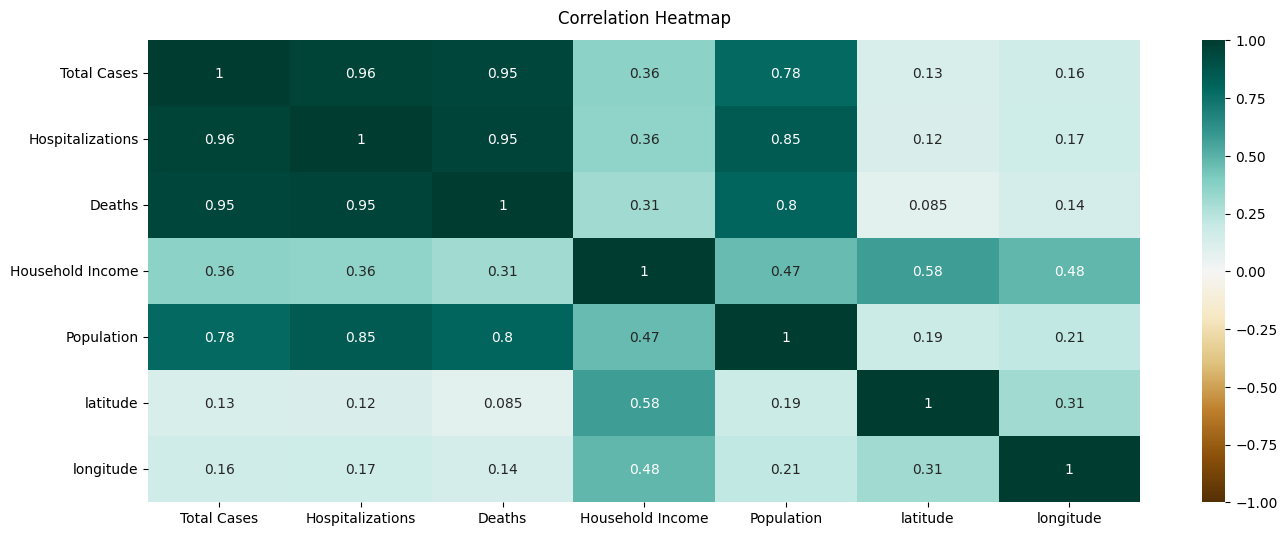

In [ ]:
# sns.heatmap(covid.corr())
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(covid.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [ ]:
corr_matrix["Total Cases"].sort_values(ascending=False)

Total Cases         1.000000
Hospitalizations    0.961213
Deaths              0.952800
Population          0.784781
Household Income    0.364540
longitude           0.161979
latitude            0.127717
Name: Total Cases, dtype: float64

In [ ]:
corr_matrix["Deaths"].sort_values(ascending=False)

Deaths              1.000000
Hospitalizations    0.954605
Total Cases         0.952800
Population          0.799221
Household Income    0.311577
longitude           0.139741
latitude            0.084913
Name: Deaths, dtype: float64

array([[<Axes: xlabel='Deaths', ylabel='Deaths'>,
        <Axes: xlabel='Hospitalizations', ylabel='Deaths'>,
        <Axes: xlabel='Total Cases', ylabel='Deaths'>,
        <Axes: xlabel='Household Income', ylabel='Deaths'>],
       [<Axes: xlabel='Deaths', ylabel='Hospitalizations'>,
        <Axes: xlabel='Hospitalizations', ylabel='Hospitalizations'>,
        <Axes: xlabel='Total Cases', ylabel='Hospitalizations'>,
        <Axes: xlabel='Household Income', ylabel='Hospitalizations'>],
       [<Axes: xlabel='Deaths', ylabel='Total Cases'>,
        <Axes: xlabel='Hospitalizations', ylabel='Total Cases'>,
        <Axes: xlabel='Total Cases', ylabel='Total Cases'>,
        <Axes: xlabel='Household Income', ylabel='Total Cases'>],
       [<Axes: xlabel='Deaths', ylabel='Household Income'>,
        <Axes: xlabel='Hospitalizations', ylabel='Household Income'>,
        <Axes: xlabel='Total Cases', ylabel='Household Income'>,
        <Axes: xlabel='Household Income', ylabel='Household Income'

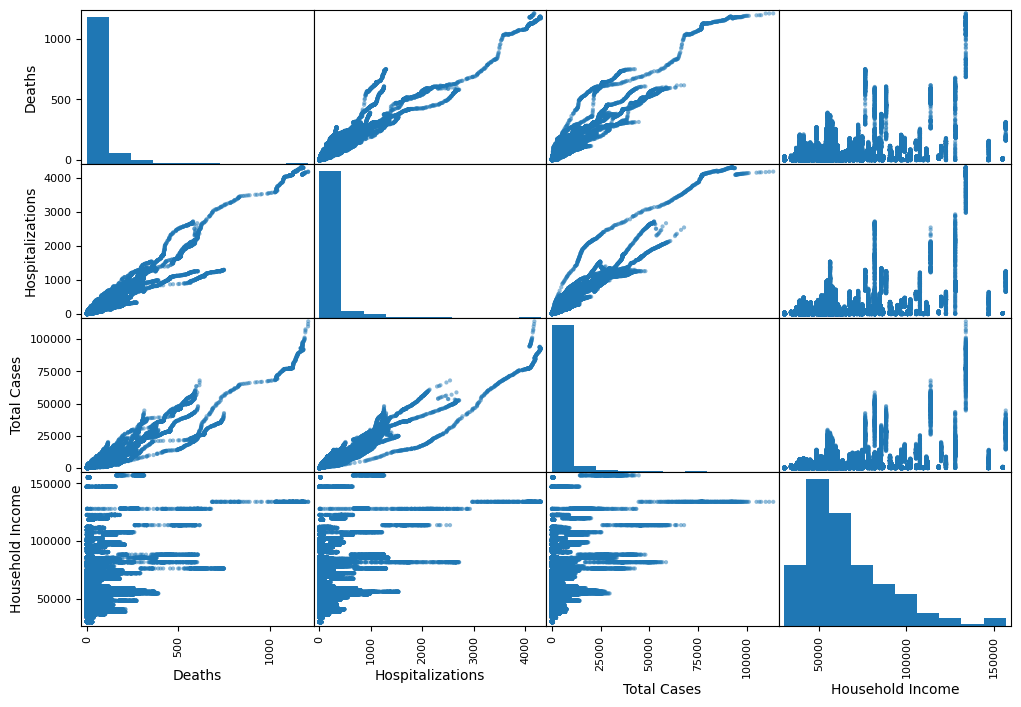

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["Deaths", "Hospitalizations", "Total Cases", "Household Income"]
scatter_matrix(covid[attributes], figsize=(12, 8))

In [ ]:
imputer = SimpleImputer(strategy="median")
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

covid_cat = covid.drop(list(covid.select_dtypes('int64')), axis=1)
covid_cat = covid_cat.drop(list(covid.select_dtypes('float64')), axis=1)
covid_num = covid.drop(list(covid.select_dtypes('object')), axis=1)

num_attribs = list(covid_num)
cat_attribs = list(covid_cat)

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("obj", OneHotEncoder(), cat_attribs),
])

covid_prepared = full_pipeline.fit_transform(covid)
print(covid_prepared.shape)

(68948, 43)


In [ ]:
# type(covid_prepared)
covid_prepared = covid_prepared.toarray()

In [ ]:
covid_prepared_df = pd.DataFrame(covid_prepared)
covid_prepared_df

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,-0.057729,-0.103196,-0.239203,0.759430,-0.293335,0.392284,0.124818,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.202909,-0.073581,-0.257455,-0.025586,0.146514,1.343272,-0.230059,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.430834,-0.418188,-0.494728,-0.675061,0.120202,-0.235430,-0.372542,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.203792,-0.232423,-0.284833,0.599259,-0.224580,0.969623,0.277508,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.114742,-0.321267,-0.412595,0.585841,-0.170829,-0.570496,0.737662,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68943,0.717491,1.404459,1.321320,-0.470431,0.257070,-1.056803,1.234312,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68944,-0.262949,-0.262038,-0.366966,0.403122,-0.367920,0.168984,0.821944,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
68945,-0.407247,-0.348189,-0.284833,-0.631621,-0.271711,-1.294228,0.104223,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
68946,-0.434113,-0.426264,-0.503854,-0.825253,0.273724,-0.441418,-0.832993,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=10, random_state=42, n_init="auto").fit(covid_prepared)

In [ ]:
covidCopy1 = covid.copy()
covidCopy1.insert(2, "labels", kmeans.labels_, True)
covidCopy1

,VDH Health District,Total Cases,labels,Hospitalizations,Deaths,Household Income,Population,latitude,longitude
82624,Blue Ridge,2996.0,4,121.0,29.0,82983,27556,37.848853,-78.278999
30136,Central Shenandoah,1845.0,1,132.0,27.0,64496,83757,38.508029,-78.894944
3438,Central Virginia,38.0,9,4.0,1.0,49201,80395,37.413754,-79.142246
45285,Rappahannock Rapidan,1838.0,4,73.0,24.0,79211,36341,38.249035,-78.013983
41700,Crater,2544.0,6,40.0,10.0,78895,43209,37.181502,-77.215314
...,...,...,...,...,...,...,...,...,...
58243,Portsmouth,9142.0,0,681.0,200.0,54020,97883,36.844420,-76.353300
67746,Three Rivers,1369.0,6,62.0,15.0,74592,18026,37.694072,-77.069028
10564,Southside,225.0,5,30.0,24.0,50224,30319,36.679848,-78.314746
1988,Roanoke,12.0,9,1.0,0.0,45664,100011,37.270973,-79.941431


In [ ]:
def plotRow(row, jitter=0.2):
  color = 'black'
  if (row[2] == 0):
    color = 'blue'
  elif (row[2] == 1):
    color = 'pink'
  elif (row[2] == 2):
    color = 'yellow'
  elif (row[2] == 3):
    color = 'red'
  elif (row[2] == 4):
    color = 'lime'
  elif (row[2] == 5):
    color = 'fuchsia'
  elif (row[2] == 6):
    color = 'darkorange'
  elif (row[2] == 7):
    color = 'slategray'
  elif (row[2] == 8):
    color = 'darkorchid'
  elif (row[2] == 9):
    color = 'sienna'
  else:
    color = 'black'
  jittered_x = row[8] + np.random.uniform(-jitter, jitter)
  jittered_y = row[7] + np.random.uniform(-jitter, jitter)

  plt.scatter(x=jittered_x, y=jittered_y, c=color)

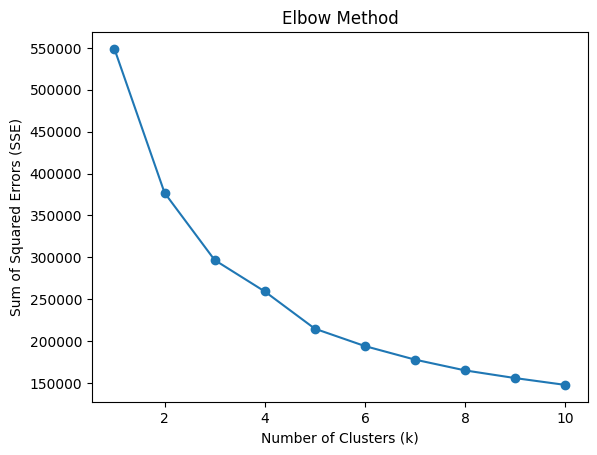

In [ ]:
k_values = range(1, 11)
sse_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(covid_prepared)
    sse_values.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(k_values, sse_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method')
plt.show()

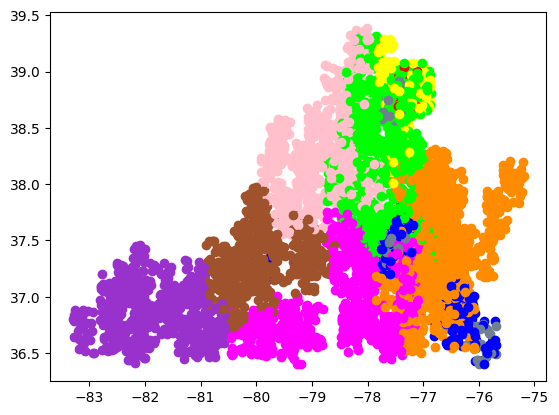

In [ ]:
for row in range(0,5000):
  plotRow(covidCopy1.iloc[row])
plt.show()

In [ ]:
kmeans6 = KMeans(n_clusters=6, random_state=42, n_init="auto").fit(covid_prepared)

In [ ]:
covidCopy2 = covid.copy()
covidCopy2.insert(2, "labels", kmeans6.labels_, True)

In [ ]:
import matplotlib.image as mpimg

def plotRow6(row, jitter=0.1):
  color = 'black'
  if (row[2] == 0):
    color = 'blue'
  elif (row[2] == 1):
    color = 'pink'
  elif (row[2] == 2):
    color = 'yellow'
  elif (row[2] == 3):
    color = 'red'
  elif (row[2] == 4):
    color = 'lime'
  elif (row[2] == 5):
    color = 'fuchsia'
  else:
    color = 'black'
  jittered_x = row[7] + np.random.uniform(-jitter, jitter)
  jittered_y = row[6] + np.random.uniform(-jitter, jitter)

  plt.scatter(x=jittered_x, y=jittered_y, c=color)

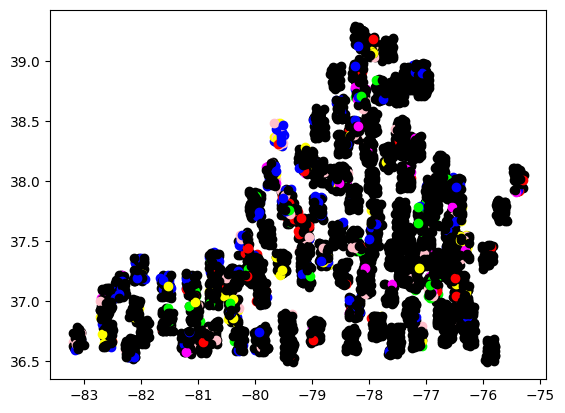

In [ ]:
for row in range(0,5000):
  plotRow6(covid.iloc[row], jitter=0.1)
plt.show()

In [ ]:
strat_train_set.head()

,VDH Health District,Total Cases,Hospitalizations,Deaths,Household Income,Population,latitude,longitude
82624,Blue Ridge,2996.0,121.0,29.0,82983,27556,37.848853,-78.278999
30136,Central Shenandoah,1845.0,132.0,27.0,64496,83757,38.508029,-78.894944
3438,Central Virginia,38.0,4.0,1.0,49201,80395,37.413754,-79.142246
45285,Rappahannock Rapidan,1838.0,73.0,24.0,79211,36341,38.249035,-78.013983
41700,Crater,2544.0,40.0,10.0,78895,43209,37.181502,-77.215314


<Axes: xlabel='longitude', ylabel='latitude'>

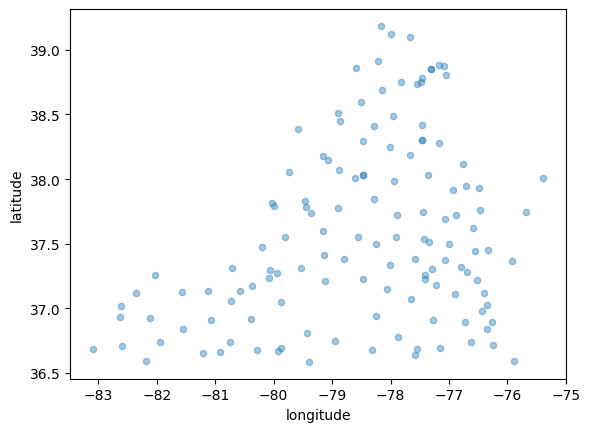

In [ ]:
df_localities.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4)

## Time Series Analysis

In [ ]:
virginia_db_url = "https://data.virginia.gov/resource/bre9-aqqr.json?$select=Locality"

json = get_api_response(virginia_db_url, "")
df_localities = pd.DataFrame(json)

,Locality
0,Accomack
1,Albemarle


In [ ]:
df_localities = df_localities.join(df_coorindates)
df_localities.head(2)

,Locality,latitude,longitude
0,Accomack,37.742221,-75.674354
1,Albemarle,38.008511,-78.608675


In [ ]:
time_series = []

for index, row in df_localities.iterrows():
  virginia_db_url = f"https://data.virginia.gov/resource/bre9-aqqr.json?$select=report_date, total_cases, hospitalizations, deaths&$where=locality='{row['Locality']}' AND report_date<'2022-01-01T00:00:00.000'&$order=report_date ASC"

  parsed_data = get_api_response(virginia_db_url, "")
  column_names = ["report_date", "total_cases", "hospitalizations", "deaths"]
  time_series_array = pd.DataFrame(parsed_data, columns=column_names)
  time_series_array.set_index("report_date",inplace=True)
  time_series_array.sort_index(inplace=True)

  time_series.append(time_series_array)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

for i in range(len(time_series)):
    scaler = MinMaxScaler()
    time_series[i] = MinMaxScaler().fit_transform(time_series[i])

print(time_series[0].shape)

(648, 3)


In [ ]:
!pip install tslearn

from tslearn.clustering import TimeSeriesKMeans

# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN
cluster_count = math.ceil(math.sqrt(len(time_series)))

km = TimeSeriesKMeans(n_clusters=4, metric="dtw")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.8/369.8 kB 6.4 MB/s eta 0:00:00


In [ ]:
labels = km.fit_predict(time_series)

In [ ]:
cluster_names = [f"Cluster {label}" for label in labels]
df_clusters = df_localities.copy()
df_clusters['Cluster'] = cluster_names
df_clusters.head(2)

,Locality,latitude,longitude,Cluster
0,Accomack,37.742221,-75.674354,Cluster 1
1,Albemarle,38.008511,-78.608675,Cluster 0


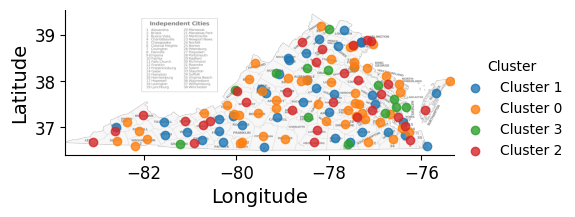

In [ ]:
import matplotlib.image as mpimg

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

virginia_img=mpimg.imread('./virginia.png')

sns.lmplot(x='longitude', y='latitude', data=df_clusters, hue='Cluster', fit_reg=False)

plt.imshow(virginia_img, extent=[-83.7, -75.3, 36.41, 39.55], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)


plt.savefig("virginia_localities_plot_5.png")
plt.show()

In [ ]:
data_2d = np.array([features_2d.flatten() for features_2d in time_series])

print(f'Silhouette Score:{silhouette_score(data_2d, km.labels_)}')

Silhouette Score:0.06065849059890301


In [ ]:
wcss = []
ss = []
for i in range(2,11):
    km = TimeSeriesKMeans(n_clusters=i, n_init=1, metric="dtw")
    print(i)
    km.fit(time_series)
    wcss.append(km.inertia_)
    ss.append(silhouette_score(data_2d, km.labels_))

#plot elbow curve
plt.plot(np.arange(2,11),wcss)
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.show()

2


KeyboardInterrupt: ignored

In [ ]:
plt.plot(np.arange(2,11),ss)
plt.xlabel('Clusters')
plt.ylabel('Silhouette')
plt.show()

In [ ]:
from sklearn.decomposition import PCA

data_2d = np.array([features_2d.flatten() for features_2d in time_series])

pca = PCA(n_components=2)

mySeries_transformed = pca.fit_transform(data_2d)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

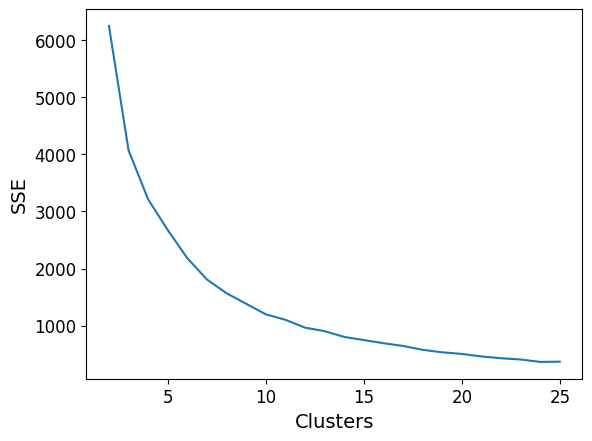

In [ ]:
wcss = []
ss = []
for i in range(2,26):
  km = KMeans(n_clusters=i,max_iter=5000)
  km.fit(mySeries_transformed)
  wcss.append(km.inertia_)
  ss.append(silhouette_score(mySeries_transformed, km.labels_))

#plot elbow curve
plt.plot(np.arange(2,26),wcss)
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.show()

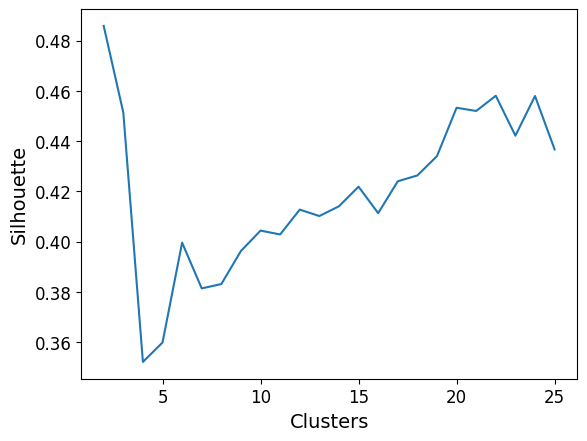

In [ ]:
plt.plot(np.arange(2,26),ss)
plt.xlabel('Clusters')
plt.ylabel('Silhouette')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=2,max_iter=5000)

labels = kmeans.fit_predict(mySeries_transformed)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
cluster_names = [f"Cluster {label}" for label in labels]
df_clusters = df_localities.copy()
df_clusters['Cluster'] = cluster_names
df_clusters.head(2)

,Locality,latitude,longitude,Cluster
0,Accomack,37.742221,-75.674354,Cluster 0
1,Albemarle,38.008511,-78.608675,Cluster 0


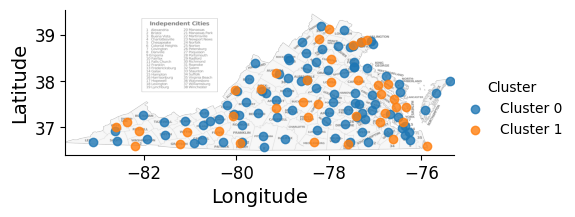

In [ ]:
import matplotlib.image as mpimg

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

virginia_img=mpimg.imread('./virginia.png')

sns.lmplot(x='longitude', y='latitude', data=df_clusters, hue='Cluster', fit_reg=False)

plt.imshow(virginia_img, extent=[-83.7, -75.3, 36.41, 39.55], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)


plt.savefig("virginia_localities_plot_5.png")
plt.show()

In [ ]:
print(f'Silhouette Score:{silhouette_score(mySeries_transformed, kmeans.labels_)}')

Silhouette Score:0.485853564219115


#-----START HERE FOR LINEAR REGRESSION-----


In [ ]:
covid = strat_train_set.copy()

In [ ]:
covid.describe()

,Total Cases,Hospitalizations,Deaths,Household Income,Population,latitude,longitude
count,68948.000000,68948.000000,68948.000000,68948.000000,6.894800e+04,68948.000000,68948.000000
mean,3453.678997,159.330735,55.211594,65098.555738,6.503638e+04,37.576941,-78.495641
std,7928.127786,371.440533,109.579442,23549.987703,1.277742e+05,0.693154,1.735669
min,0.000000,0.000000,0.000000,30058.000000,2.226000e+03,36.585972,-83.097321
25%,265.000000,18.000000,5.000000,49486.000000,1.477500e+04,37.024130,-79.590798
50%,1138.000000,53.000000,21.000000,57911.000000,2.587400e+04,37.445229,-78.149582
75%,3077.250000,136.000000,60.000000,76528.000000,5.447700e+04,38.032030,-77.215314
max,113641.000000,4301.000000,1209.000000,156821.000000,1.150309e+06,39.185218,-75.383530


array([[<Axes: xlabel='Deaths', ylabel='Deaths'>,
        <Axes: xlabel='Hospitalizations', ylabel='Deaths'>,
        <Axes: xlabel='Total Cases', ylabel='Deaths'>,
        <Axes: xlabel='Household Income', ylabel='Deaths'>,
        <Axes: xlabel='latitude', ylabel='Deaths'>,
        <Axes: xlabel='longitude', ylabel='Deaths'>,
        <Axes: xlabel='Population', ylabel='Deaths'>],
       [<Axes: xlabel='Deaths', ylabel='Hospitalizations'>,
        <Axes: xlabel='Hospitalizations', ylabel='Hospitalizations'>,
        <Axes: xlabel='Total Cases', ylabel='Hospitalizations'>,
        <Axes: xlabel='Household Income', ylabel='Hospitalizations'>,
        <Axes: xlabel='latitude', ylabel='Hospitalizations'>,
        <Axes: xlabel='longitude', ylabel='Hospitalizations'>,
        <Axes: xlabel='Population', ylabel='Hospitalizations'>],
       [<Axes: xlabel='Deaths', ylabel='Total Cases'>,
        <Axes: xlabel='Hospitalizations', ylabel='Total Cases'>,
        <Axes: xlabel='Total Cases', yla

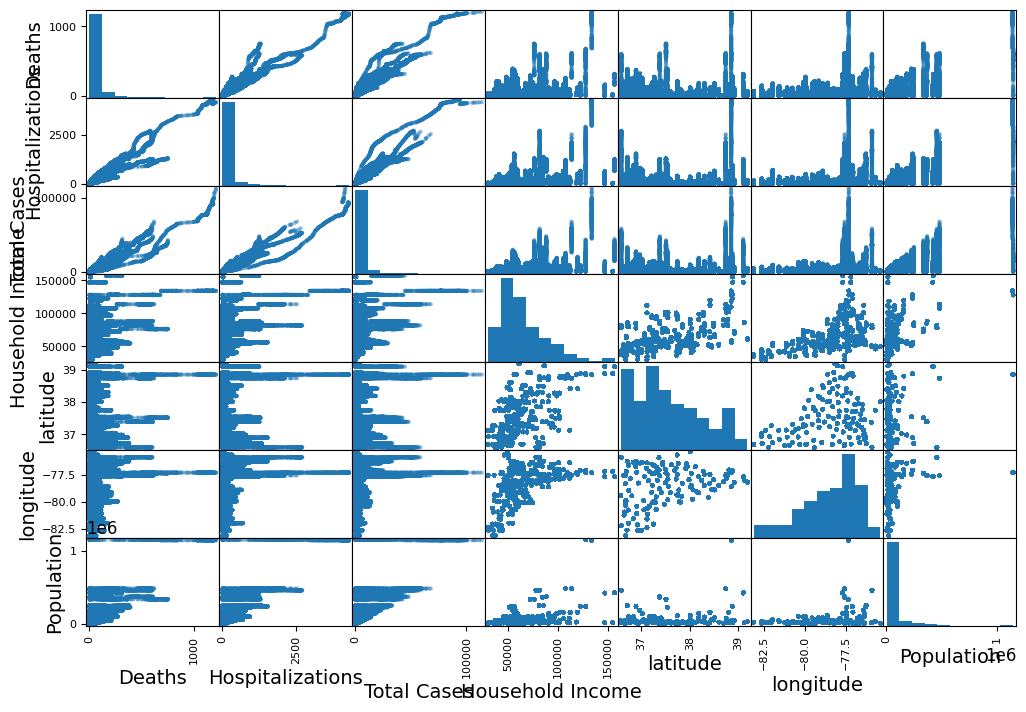

In [ ]:
attributes = ["Deaths", "Hospitalizations", "Total Cases",
             "Household Income", "latitude", "longitude", "Population"]
scatter_matrix(covid[attributes], figsize=(12, 8))

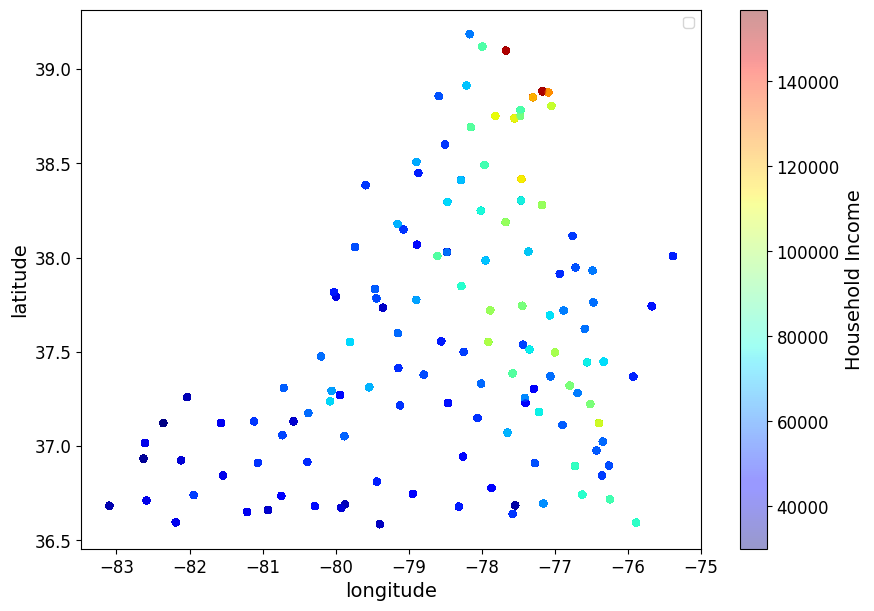

In [ ]:
covid.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    figsize=(10,7), c="Household Income", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

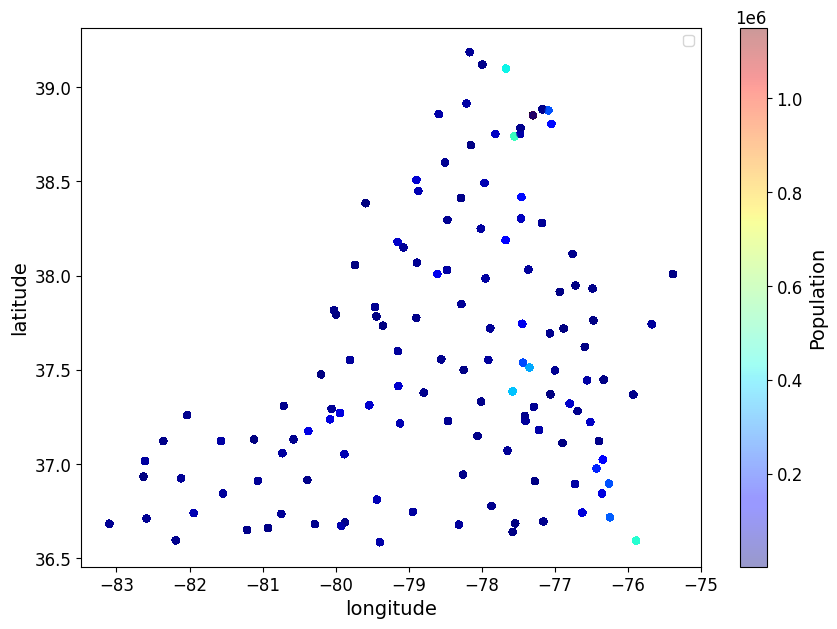

In [ ]:
covid.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    figsize=(10,7), c="Population", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

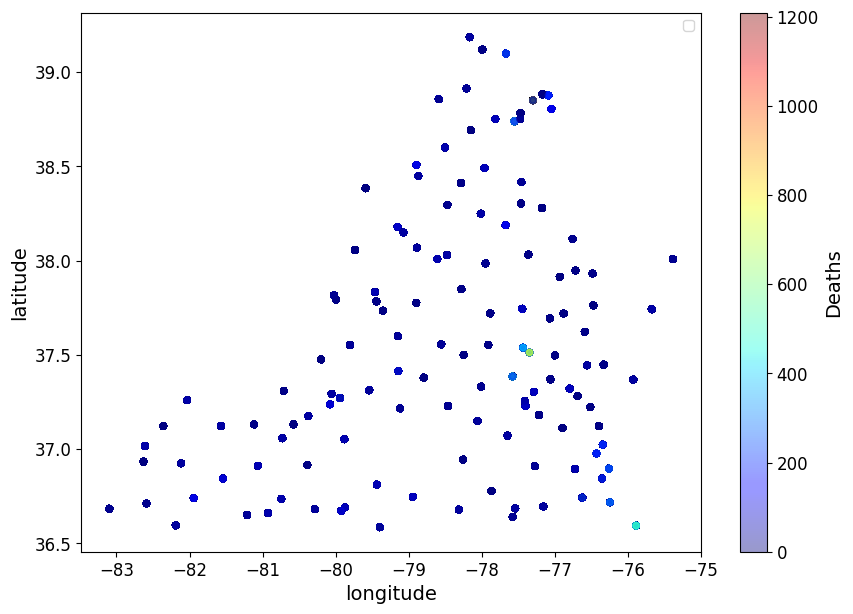

In [ ]:
covid.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    figsize=(10,7), c="Deaths", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

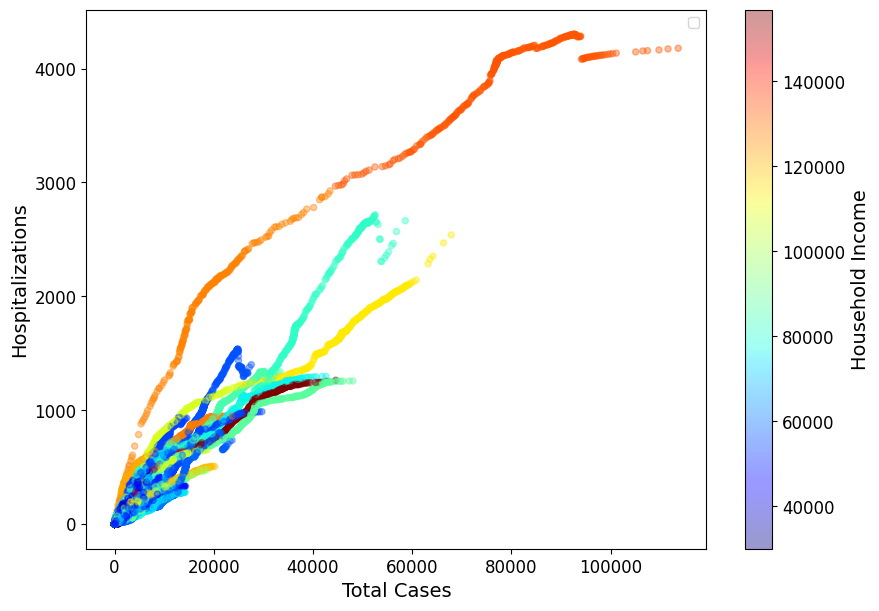

In [ ]:
covid.plot(kind="scatter", x="Total Cases", y="Hospitalizations", alpha=0.4,
    figsize=(10,7), c="Household Income", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
# This is different from what we expected, as we thought the Total Hospitalizations and Total Cases
# would be higher for localities with lower Household Income, but this was not the case.

In [ ]:
corr_matrix = covid.corr()
corr_matrix['Deaths'].sort_values(ascending=False)

<ipython-input-49-0c8f6a5d0e79>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = covid.corr()


Deaths              1.000000
Hospitalizations    0.954605
Total Cases         0.952800
Population          0.799221
Household Income    0.311577
longitude           0.139741
latitude            0.084913
Name: Deaths, dtype: float64

In [ ]:
# Hospitalizations, Total Cases, and Deaths are too closely related, and the model relies too heavily on them, so we have to drop all 3 and
# choose one to predict
dropped_attribs = ["Deaths", "Total Cases", "Hospitalizations"]
covid = strat_train_set.drop(dropped_attribs, axis=1)

# Create Labels for predicting Deaths
covid_labels = strat_train_set["Deaths"].copy()

In [ ]:
# Create Pipelines

imputer = SimpleImputer(strategy="median")
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

covid_cat = covid.drop(list(covid.select_dtypes('int64')), axis=1)
covid_cat = covid_cat.drop(list(covid.select_dtypes('float64')), axis=1)
covid_num = covid.drop(list(covid.select_dtypes('object')), axis=1)

num_attribs = list(covid_num)
cat_attribs = list(covid_cat)

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("obj", OneHotEncoder(), cat_attribs),
])

covid_prepared = full_pipeline.fit_transform(covid)
print(covid_prepared.shape)

(68948, 40)


In [ ]:
# Choosing a Model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(covid_prepared, covid_labels)

LinearRegression()

In [ ]:
# Try the full preprocessing pipeline on a few training instances
some_data = covid.iloc[:5]
some_labels = covid_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [27.8301765  65.38986494 67.95171257 26.28768245 43.72144295]
Labels: [29.0, 27.0, 1.0, 24.0, 10.0]


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

covid_predictions = lin_reg.predict(covid_prepared)
lin_mse = mean_squared_error(covid_labels, covid_predictions)
lin_rmse = np.sqrt(lin_mse)
print("Linear RMSE: ", lin_rmse)

lin_mae = mean_absolute_error(covid_labels, covid_predictions)
print("Linear MAE: ", lin_mae)

Linear RMSE:  61.77248659983824
Linear MAE:  35.16923470607478


In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [ ]:
lin_scores = cross_val_score(lin_reg, covid_prepared, covid_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [63.94513711 59.99647697 59.13464878 60.73720056 62.75833593 64.12789739
 62.06362673 60.02569454 64.1972303  61.21244762]
Mean: 61.81986959266576
Standard deviation: 1.7813226583326205


In [ ]:
# Decision Tree Regressor (Random Forest Regressor takes too long to run)
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(covid_prepared, covid_labels)

scores = cross_val_score(tree_reg, covid_prepared, covid_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
print(tree_rmse_scores)

[28.25016354 27.45595068 28.40397997 27.24913221 27.26152944 29.62193637
 28.79927972 27.11153643 29.72107937 27.99528491]


In [ ]:
display_scores(tree_rmse_scores)

Scores: [28.25016354 27.45595068 28.40397997 27.24913221 27.26152944 29.62193637
 28.79927972 27.11153643 29.72107937 27.99528491]
Mean: 28.186987262547905
Standard deviation: 0.9111695636507741


In [ ]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(covid_prepared, covid_labels)

RandomForestRegressor(random_state=42)

In [ ]:
covid_predictions = forest_reg.predict(covid_prepared)
forest_mse = mean_squared_error(covid_labels, covid_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

28.091421906481003

In [ ]:
forest_scores = cross_val_score(forest_reg, covid_prepared, covid_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [28.24956062 27.47672122 28.40226095 27.24324617 27.2671132  29.63153473
 28.79525071 27.10373241 29.72578973 27.9783263 ]
Mean: 28.187353603263112
Standard deviation: 0.9128606438966541


In [ ]:
scores = cross_val_score(lin_reg, covid_prepared, covid_labels, scoring="neg_mean_squared_error", cv=5)
pd.Series(np.sqrt(-scores)).describe()

count     5.000000
mean     61.814493
std       1.374682
min      59.945099
25%      61.014104
50%      61.987663
75%      62.690497
max      63.435104
dtype: float64

##Fine Tuning

In [ ]:
# Grid Search
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(tree_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(covid_prepared, covid_labels)
best_params = grid_search.best_params_
best_dt_regressor = DecisionTreeRegressor(**best_params)
best_dt_regressor.fit(covid_prepared, covid_labels)

scores = cross_val_score(tree_reg, covid_prepared, covid_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [28.25016354 27.45595068 28.40397997 27.24913221 27.26152944 29.62193637
 28.79927972 27.11153643 29.72107937 27.99528491]
Mean: 28.186987262547905
Standard deviation: 0.9111695636507741


In [ ]:
# grid_search.best_params_

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

28.20926180194211 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
28.20926180194211 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
28.20926180194211 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
28.209350376642238 {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
28.209350376642238 {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
28.209350376642238 {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
28.209806005769316 {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
28.209806005769316 {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5}
28.209806005769316 {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
49.15495819990291 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
49.15495819990291 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
49.15495819990291 {'max_depth': 5, 'min_samples_leaf': 1, 'min

In [ ]:
# Randomized Search CV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'max_depth': [None] + list(np.arange(5, 30, 1)),
        'min_samples_split': list(np.arange(2, 21, 1)),
        'min_samples_leaf': list(np.arange(1, 9, 1)),
        'max_features': ['auto', 'sqrt', 'log2'] + list(range(1, covid_prepared.shape[1]))
    }

dt_reg = DecisionTreeRegressor(random_state=42)
rnd_search = RandomizedSearchCV(dt_reg, param_distributions=param_distribs,
                                n_iter=10, cv=10, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(covid_prepared, covid_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/di

RandomizedSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=42),
                   param_distributions={'max_depth': [None, 5, 6, 7, 8, 9, 10,
                                                      11, 12, 13, 14, 15, 16,
                                                      17, 18, 19, 20, 21, 22,
                                                      23, 24, 25, 26, 27, 28,
                                                      29],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         21, 22, 23, 24, 25, 26,
                                                         27, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19, 20]},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

35.849349858512966 {'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 2, 'max_depth': 23}
28.20173134181731 {'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 27}
28.202557633484222 {'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': 25, 'max_depth': 24}
29.691911965319616 {'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 8, 'max_depth': 20}
28.202373773540703 {'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 30, 'max_depth': 22}
29.36010582902506 {'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 9, 'max_depth': 21}
30.778132632097936 {'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 23, 'max_depth': 12}
28.22454060376438 {'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 19, 'max_depth': 25}
28.329988484830434 {'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 27, 'max_depth': 17}
28.206829421477682 {'min_samples_split': 2, 'min_samples_le

In [ ]:
covid.head()

,VDH Health District,Household Income,Population,latitude,longitude
82624,Blue Ridge,82983,27556,37.848853,-78.278999
30136,Central Shenandoah,64496,83757,38.508029,-78.894944
3438,Central Virginia,49201,80395,37.413754,-79.142246
45285,Rappahannock Rapidan,79211,36341,38.249035,-78.013983
41700,Crater,78895,43209,37.181502,-77.215314


In [ ]:
# Feature Importances of Decision Tree
feature_importances = grid_search.best_estimator_.feature_importances_
attributes = num_attribs + cat_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.8097191400727092, 'Population'),
 (0.1472203767151572, 'Household Income'),
 (0.00986511223185212, 'latitude'),
 (0.006356357656495131, 'longitude'),
 (0.0, 'VDH Health District')]

In [ ]:
# Feature Importances of Random Forest
feature_importances = rnd_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, attributes), reverse=True)

[(0.8037962630753605, 'Population'),
 (0.15048189650311472, 'Household Income'),
 (0.009937701149036415, 'latitude'),
 (0.009702668570598469, 'longitude'),
 (0.0, 'VDH Health District')]

##Final Predictions

In [ ]:
# Decision Tree
from scipy import stats

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("Deaths", axis=1)
y_test = strat_test_set["Deaths"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

lin_mae = mean_absolute_error(y_test, final_predictions)

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2

print("Final RMSE: ", final_rmse)
print("Final MAE: ", lin_mae)
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

Final RMSE:  28.3390154460645
Final MAE:  12.410505332615244


array([26.73048146, 29.86102734])

In [ ]:
# Random Forest

final_model = rnd_search.best_estimator_

X_test = strat_test_set.drop("Deaths", axis=1)
y_test = strat_test_set["Deaths"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

lin_mae = mean_absolute_error(y_test, final_predictions)

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2

print("Final RMSE: ", final_rmse)
print("Final MAE: ", lin_mae)
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

Final RMSE:  28.339273301251062
Final MAE:  12.412056502149738


array([26.73075536, 29.86127158])